# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Getting data directory

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/IUS/data_new.csv')
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3967 entries, 0 to 3966
Columns: 2523 entries, -0.00024623 to -0.0023332
dtypes: float64(2523)
memory usage: 76.4 MB


## Mapping Images into a dataframe

In [ ]:
data_start_date = df.columns[0]
#data_end_date = df.columns[-1]
data_end_date = df.columns[-1]

In [ ]:
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from -0.00024623 to -0.0023332


## Visualizing RF signal

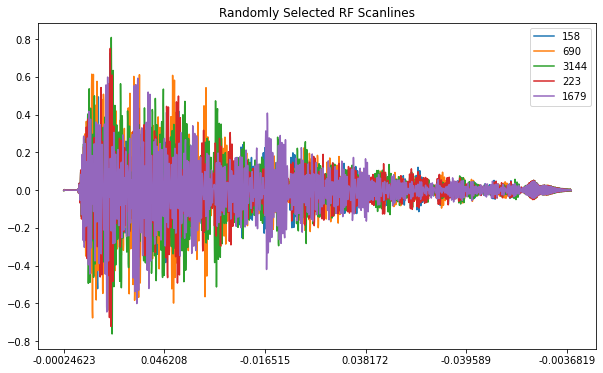

In [ ]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    #page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    sample_index =sample.T.columns.values
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        (pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
        
    
    plt.title('Randomly Selected RF Scanlines')
    plt.legend(sample_index)
    
plot_random_series(df, 5)

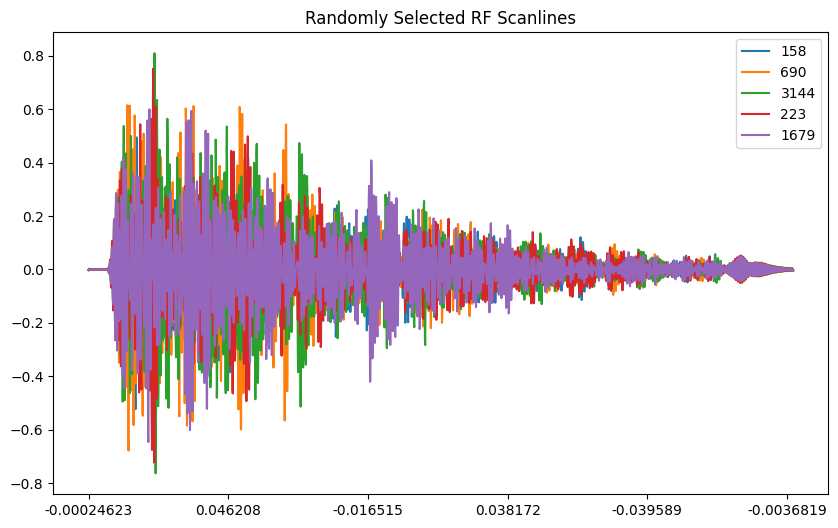

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_series(df, n_series):
    sample = df.sample(n_series, random_state=8)
    series_samples = sample.loc[:, data_start_date:data_end_date]
    sample_index = sample.T.columns.values
    plt.figure(figsize=(10, 6))
    
    for i in range(series_samples.shape[0]):
        (pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
        
    plt.title('Randomly Selected RF Scanlines')
    plt.legend(sample_index)

# Assuming you already have a DataFrame 'df'
plot_random_series(df, 5)

## Data Processing

In [ ]:
#from datetime import timedelta

#pred_steps = 50
pred_steps = 100
pred_length = pred_steps 

In [ ]:
first_day = int(float(data_start_date))-1
last_day = int(float(data_end_date))-1


In [ ]:
val_pred_start = 1100
val_pred_end = 1199

In [ ]:
train_pred_start = 1000
train_pred_end = 1099

In [ ]:
enc_length = 500


In [ ]:
train_enc_start = 500
train_enc_end = train_enc_start + enc_length - 1

In [ ]:
val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length -1 

In [ ]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length)
print('Prediction interval:', pred_length)

Train encoding: 500 - 999
Train prediction: 1000 - 1099 

Val encoding: 600 - 1099
Val prediction: 1100 - 1199

Encoding interval: 500
Prediction interval: 100


In [ ]:
#date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                         # data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[0:]].values  #converting the indexed array to non-indexed array for keras-friendly version

In [ ]:
def get_time_block_series(series_array, start_date, end_date): # function to extract specified time interval from all series
    
    #inds = date_to_index[start_date:end_date]
    inds = list(range(start_date,end_date+1))
    return series_array[:,inds]

In [ ]:
def transform_series_encode(series_array): # we need this only to convert the array to a keras compatible (3D) array
    
    #series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    #series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

In [ ]:
def transform_series_decode(series_array, encode_series_mean):
    
  #  series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    #series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.optimizers import SGD

## Defining LSTM Encoder Decoder Model

In [ ]:
latent_dim = 50 # LSTM hidden units
dropout = .20 

In [ ]:
# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [ ]:
# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

In [ ]:
# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

In [ ]:
decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 50),         10400       ['input_1[0][0]']                
                                 (None, 50),                                                      
                                 (None, 50)]                                                      
                                                                                              

In [ ]:
first_n_samples = 4000
batch_size = 2**7
epochs =1000

In [ ]:
# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

In [ ]:
# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array,
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)


In [ ]:
# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

In [ ]:
model.compile(Adam(), loss='mean_absolute_error',metrics=['mean_absolute_error','MSE'])    #before training a model, we need to configure the learning process, a metric can be speified as well
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/1000
25/25 [==============================] - 5s 60ms/step - loss: 0.0283 - mean_absolute_error: 0.0283 - MSE: 0.0015 - val_loss: 0.0185 - val_mean_absolute_error: 0.0185 - val_MSE: 5.4601e-04
Epoch 2/1000
25/25 [==============================] - 1s 28ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - MSE: 0.0015 - val_loss: 0.0193 - val_mean_absolute_error: 0.0193 - val_MSE: 5.8607e-04
Epoch 3/1000
25/25 [==============================] - 1s 34ms/step - loss: 0.0273 - mean_absolute_error: 0.0273 - MSE: 0.0015 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195 - val_MSE: 6.0956e-04
Epoch 4/1000
25/25 [==============================] - 1s 34ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - MSE: 0.0015 - val_loss: 0.0192 - val_mean_absolute_error: 0.0192 - val_MSE: 5.8419e-04
Epoch 5/1000
25/25 [==============================] - 1s 33ms/step - loss: 0.0271 - mean_absolute_error: 0.0271 - MSE: 0.0015 - val_loss: 0.0190 - val_mean_absolute_error: 0.0190 - val_MSE: 5.7148

## Mapping encoder sequence to state vectors

In [ ]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

In [ ]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

## Prediction

1/1 [==============================] - 0s 23ms/step


array([[-0.07928824],
       [-0.12749518],
       [-0.07890128],
       [ 0.01812839],
       [ 0.10707359],
       [ 0.12949401],
       [ 0.06885733],
       [-0.03381611],
       [-0.10636637],
       [-0.11007782],
       [-0.04809672],
       [ 0.03077519],
       [ 0.08104049],
       [ 0.07334967],
       [ 0.02461173],
       [-0.02751997],
       [-0.04750938],
       [-0.02861645],
       [ 0.00847078],
       [ 0.03915929],
       [ 0.03797008],
       [ 0.00843607],
       [-0.02714484],
       [-0.04737271],
       [-0.0441328 ],
       [-0.02343234],
       [-0.00083482],
       [ 0.01592233],
       [ 0.03165661],
       [ 0.05017333],
       [ 0.06483365],
       [ 0.06035938],
       [ 0.02453998],
       [-0.0360497 ],
       [-0.09490956],
       [-0.12528574],
       [-0.10977887],
       [-0.04662139],
       [ 0.0437642 ],
       [ 0.12647988],
       [ 0.16355497],
       [ 0.13370435],
       [ 0.04814864],
       [-0.05933144],
       [-0.13802905],
       [-0

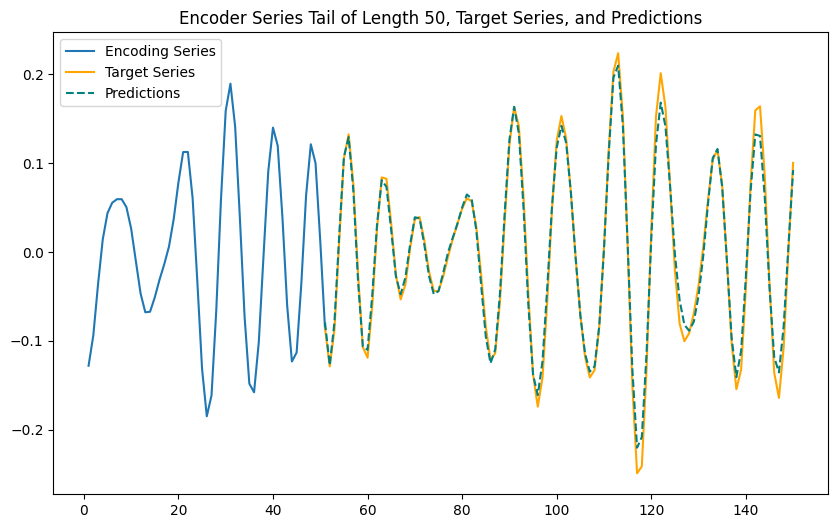

In [ ]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series

predict_and_plot(encoder_input_data, decoder_target_data,3002,enc_tail_len=50)
#predict_and_plot(encoder_input_data, decoder_target_data,3020,enc_tail_len=50)
#predict_and_plot(encoder_input_data, decoder_target_data,302,enc_tail_len=50)


1/1 [==============================] - 0s 34ms/step


array([[-0.085733 ],
       [-0.12884  ],
       [-0.087559 ],
       [ 0.012245 ],
       [ 0.10581  ],
       [ 0.13252  ],
       [ 0.076119 ],
       [-0.025502 ],
       [-0.10689  ],
       [-0.11905  ],
       [-0.060313 ],
       [ 0.02612  ],
       [ 0.084141 ],
       [ 0.082455 ],
       [ 0.032064 ],
       [-0.02634  ],
       [-0.053303 ],
       [-0.036677 ],
       [ 0.0043542],
       [ 0.037067 ],
       [ 0.039445 ],
       [ 0.013156 ],
       [-0.021824 ],
       [-0.043904 ],
       [-0.043971 ],
       [-0.027455 ],
       [-0.0056911],
       [ 0.014129 ],
       [ 0.031798 ],
       [ 0.0487   ],
       [ 0.06071  ],
       [ 0.057182 ],
       [ 0.028294 ],
       [-0.024546 ],
       [-0.083798 ],
       [-0.12159  ],
       [-0.11397  ],
       [-0.055472 ],
       [ 0.034986 ],
       [ 0.12072  ],
       [ 0.16354  ],
       [ 0.14174  ],
       [ 0.060988 ],
       [-0.047022 ],
       [-0.13791  ],
       [-0.17408  ],
       [-0.14144  ],
       [-0.05

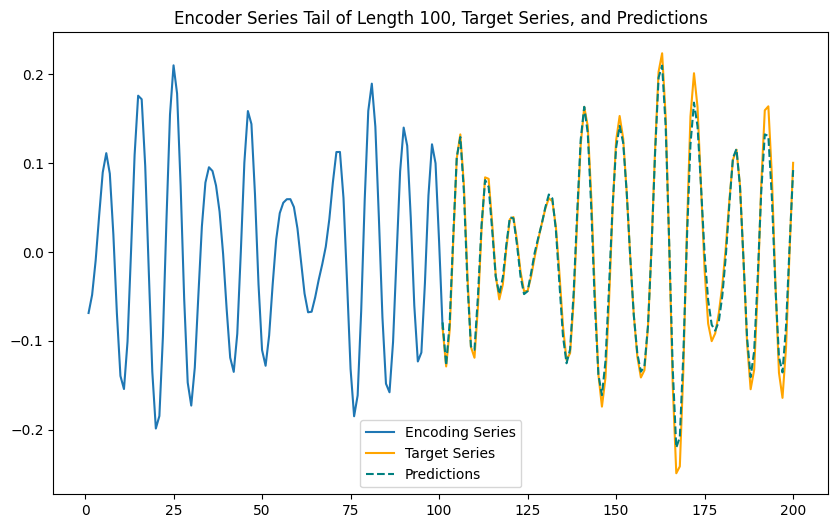

In [ ]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return target_series

predict_and_plot(encoder_input_data, decoder_target_data,3002,enc_tail_len=100)
#predict_and_plot(encoder_input_data, decoder_target_data,3020,enc_tail_len=50)
#predict_and_plot(encoder_input_data, decoder_target_data,302,enc_tail_len=50)


1/1 [==============================] - 0s 19ms/step


array([[-0.07928824],
       [-0.12749518],
       [-0.07890128],
       [ 0.01812839],
       [ 0.10707359],
       [ 0.12949401],
       [ 0.06885733],
       [-0.03381611],
       [-0.10636637],
       [-0.11007782],
       [-0.04809672],
       [ 0.03077519],
       [ 0.08104049],
       [ 0.07334967],
       [ 0.02461173],
       [-0.02751997],
       [-0.04750938],
       [-0.02861645],
       [ 0.00847078],
       [ 0.03915929],
       [ 0.03797008],
       [ 0.00843607],
       [-0.02714484],
       [-0.04737271],
       [-0.0441328 ],
       [-0.02343234],
       [-0.00083482],
       [ 0.01592233],
       [ 0.03165661],
       [ 0.05017333],
       [ 0.06483365],
       [ 0.06035938],
       [ 0.02453998],
       [-0.0360497 ],
       [-0.09490956],
       [-0.12528574],
       [-0.10977887],
       [-0.04662139],
       [ 0.0437642 ],
       [ 0.12647988],
       [ 0.16355497],
       [ 0.13370435],
       [ 0.04814864],
       [-0.05933144],
       [-0.13802905],
       [-0

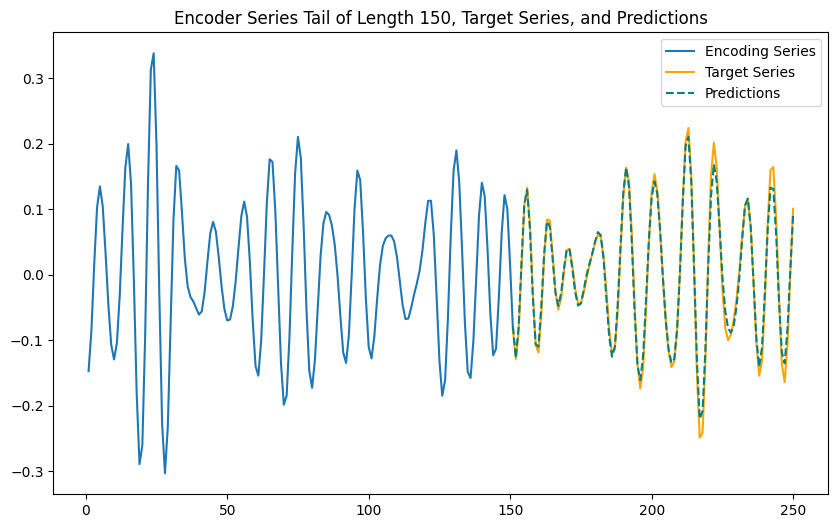

In [ ]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series

predict_and_plot(encoder_input_data, decoder_target_data,3002,enc_tail_len=150)
#predict_and_plot(encoder_input_data, decoder_target_data,3020,enc_tail_len=50)
#predict_and_plot(encoder_input_data, decoder_target_data,302,enc_tail_len=50)
